In [1]:
import multipers as mp
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt

# Core functions of the library

## Toy examples

This notebook will showcase how to use the multipers library core functions. As it relies on gudhi code, the syntax is almost the same.

The example we provide can be tweaked in different ways; don't hesitate to read the functions documentations to figure out how to do so.

In [2]:
st = gd.SimplexTree() # usual gudhi simplextree
st.insert([0,1],0)
st.insert([1],1)
# converts the simplextree into a multiparameter simplextree
st_multi = mp.SimplexTreeMulti(st, num_parameters =2) 
list(st_multi.get_simplices())

[(array([0, 1]), array([  0., -inf], dtype=float32)),
 (array([0]), array([  0., -inf], dtype=float32)),
 (array([1]), array([  0., -inf], dtype=float32))]

In [3]:
st = mp.SimplexTreeMulti(num_parameters=2) # multiparameter syntax
st.insert([0],[0,1])
st.insert([1],[1,0])
st.insert([0,1],[1,1])
list(st.get_simplices()) # list of (simplex, filtration)

[(array([0, 1]), array([1., 1.], dtype=float32)),
 (array([0]), array([0., 1.], dtype=float32)),
 (array([1]), array([1., 0.], dtype=float32))]

Almost all methods of gudhi simplextree should work ootb on simplextreemultis, and some are reimplemented, e.g., make_filtration_non_decreasing, expand, edge_collapse. 

Furthermore, some methods are removed, e.g., persistence, and are replaced by other topological invariants. For instance interval approximations, provided by `MMA` (wich comes itself with its own `PyModule` structure), or signed measures derived from the dimension vector of the module or the Euler characteristic.

([[0.0, 1.0], [1.0, 0.0]], [[inf, inf]])

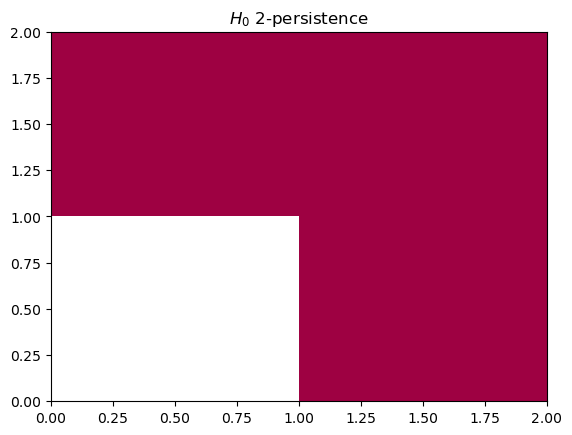

In [4]:
mma_pymodule = st.persistence_approximation()
mma_pymodule.plot(degree=0, box=[[0,0],[2,2]])
mma_pymodule[0].get_birth_list(), mma_pymodule[0].get_death_list()

The signed measure obtained by the degree 0 homology can be retrieved using

In [5]:
mp.signed_measure(st, degree=0, mass_default=None)

[(array([[0., 1.],
         [1., 0.],
         [1., 1.]]),
  array([ 1,  1, -1]))]

And the signed measure obtained via the euler characteristic (`degree=None`) 

In [6]:
mp.signed_measure(st,mass_default=None)

[(array([[0., 1.],
         [1., 0.],
         [1., 1.]]),
  array([ 1,  1, -1]))]

## On point clouds

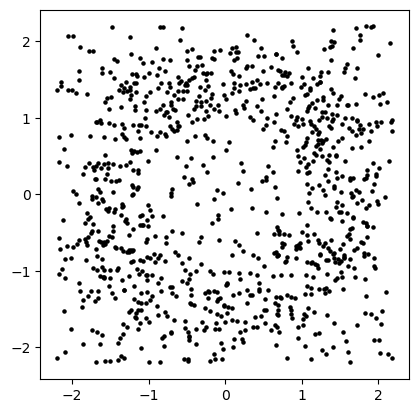

In [7]:
# Dataset
X = mp.noisy_annulus(n1=500, n2=500) # 1000 points on the annulus, 500 points on the square.
plt.scatter(X[:,0], X[:,1], s=5, c='k');plt.gca().set_aspect(1);
# Gudhi SimplexTree
st = gd.RipsComplex(points=X, max_edge_length=2.1).create_simplex_tree()
# SimplexTreeMulti, with 2 parameters
st = mp.SimplexTreeMulti(st, num_parameters=2)

`st` is now a SimplexTreeMulti, whose first parameter is a rips, and the second parameter is undefined.

Let's fill the second parameter.

In [8]:
from multipers.ml.convolutions import KDE as KernelDensity
codensity = - KernelDensity(bandwidth=0.2).fit(X).score_samples(X) 
# parameter = 1 is the second parameter as python starts with 0.
st.fill_lowerstar(codensity, parameter=1) # This fills the second parameter with the co-log-density

<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


Note that the KernelDensity is a (faster) reimplementation of sklearn's KernelDensity, using PyKeops, which allows us to do automatic-differentiation.

**Remark :** A rips complex contains **a lot** of unnecessary edges, which can make the filtration grid prohibitly large; we will simplificate the simplextree, before computing this exact grid. This can be done using the `collapse_edges` method, which relies on [filtration_domination](https://github.com/aj-alonso/filtration_domination).

In [9]:
print("Before edge collapses :", st.num_simplices)
st.collapse_edges(full=True, progress=True) # This should take less than 20s
print("After edge collapses :", st.num_simplices)
st.expansion(2) # Be careful, we have to expand the dimension to 2 before computing degree 1 homology.
print("After expansion :", st.num_simplices)

Before edge collapses : 234095


Removing edges:  25%|██▌       | 25/100 [00:05<00:16,  4.65it/s]

After edge collapses : 5183
After expansion : 12218


### Interval decomposition approximation

To get an idea of the shape of the module, we can compute first an approximation of it, using `MMA`.

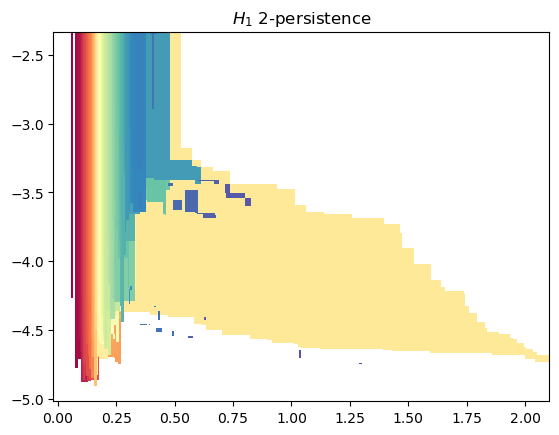

In [10]:
st.persistence_approximation().plot(degree=1) # Should take less than ~10 seconds depending on the seed

### Signed Barcode Decompositions

Another interesting topological invariants are signed measures given by module decompositions. Unlike `MMA`, they heavily rely on computation on a fixed grid, so in order to significantly reduce the computational time, we can `coarsen` the multi-filtration before doing the computations. This can be done using the `grid_squeeze` method.

The easiest measure to compute on point cloud is the one given by the decomposition of the hilbert function, i.e., the pointwise dimension of the module.

In [11]:
st_coord = mp.SimplexTreeMulti(st) # We do a copy first (for later use), as this changes the filtration values.
st_coord.grid_squeeze(grid_strategy="exact") # exact filtration

In [12]:
list(st_coord.get_simplices())[:3] # filtration values are now integers : the coordinates in that grid

[(array([  0,   4, 833]), array([1071.,  725.], dtype=float32)),
 (array([  0,   4, 961]), array([2924.,  946.], dtype=float32)),
 (array([0, 4]), array([693., 725.], dtype=float32))]

We can now compute the signed measure of degree 1 of this complex.

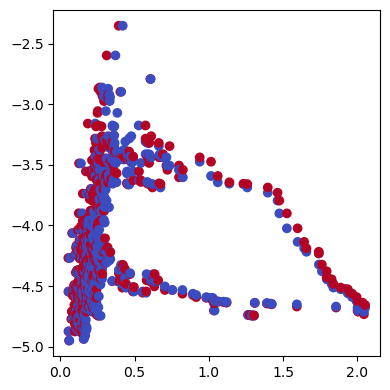

In [13]:
# The zero pad zeros out the grid, should take less than ~10s
sm_hilbert = mp.signed_measure(st_coord,degrees=[1], plot=True, mass_default=None, invariant="hilbert") 

Note that the Euler signed measure **cannot** be computed here (unless you have a **lot** of RAM), as one would need to do a `st.expansion(#num_verticies)` beforehand.

This is why we **need to simplificate** the original multi-filtration, by using a grid of lower resolution. 

In [14]:
F = st.get_filtration_grid(grid_strategy="regular", resolution=200)
[len(f) for f in F]

[200, 200]

In [15]:
st_coord = mp.SimplexTreeMulti(st)
st_coord.grid_squeeze(F) # Squeezing simplificates the multi-filtration,  thus we can collapse edges again :)
st_coord.collapse_edges(full=True, progress=True, ignore_warning=True)
st_coord.expansion(st_coord.num_vertices)
st_coord.num_simplices

Removing edges:  10%|█         | 10/100 [00:00<00:02, 32.30it/s]


23561

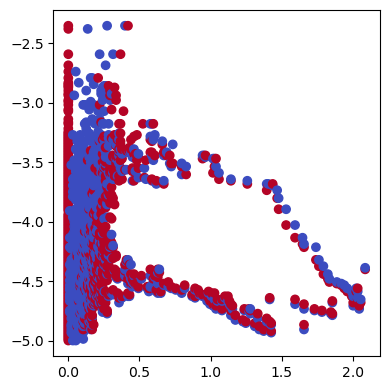

In [16]:
# should be instantaneous
sm_euler = mp.signed_measure(st_coord,degree=None,plot=True) # degree=None automatically calls the euler invariant, and integers the hilbert invariant

Finally, the measure given by the rank decomposition has an even worse scaling with the grid size, so we recommend decreasing the grid size before computing this measure

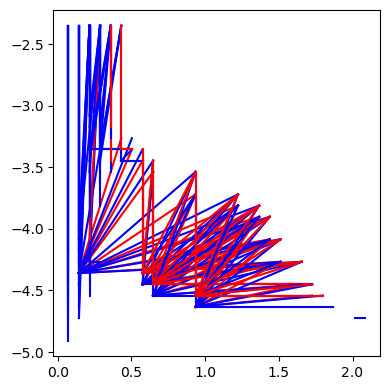

In [17]:
## The rank invariant can be even slower to compute; it is in particular very affected by the resolution.
st_coord = mp.SimplexTreeMulti(st)
st_coord.grid_squeeze(grid_strategy="regular", resolution=30)
mp.signed_measure(st_coord,degrees=[1], plot=True, invariant="rank_invariant");

## Signed Measure Vectorizations

### Sliced Wasserstein

For the slicedwasserstein distances, and the convolutions of the signed measures, we recommend to use the already provided pipelines :
 - `multipers.ml.multi.SignedMeasure2Convolution`
 - `multipers.ml.multi.SignedMeasure2SlicedWassersteinDistance`

Note that the second one **needs** signed measures of null mass. So set the `zero_pad` flag to `True` when using these pipelines.

In [18]:
from multipers.ml.signed_measures import SignedMeasure2Convolution, SignedMeasure2SlicedWassersteinDistance

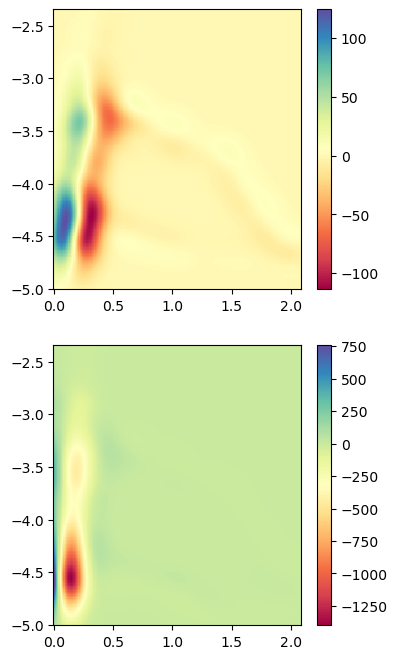

In [19]:
imgs = SignedMeasure2Convolution(plot=True,bandwidth=0.1, infer_grid_strategy='regular', resolution=200).fit_transform([sm_hilbert, sm_euler])